# Optimierung

In der Datenanalyse wird häufig versucht eine Modellfunktion zur interpretation der Daten zu nutzen. Solche Modellfunktionen können beispielsweise Polynome sein, deren Koeffizienten anhand der gegebenen Daten bestimmt werden um diese durch die Modellfunktion bestmöglich darzustellen. In diesem Kapitel wird ein allgemeiner Ansatz für das Fitten einer beliebigen Modellfunktion vorgestellt.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rc('figure', dpi=150)

import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})

Zur Demonstration, wird zunächst ein Datensatz generiert.

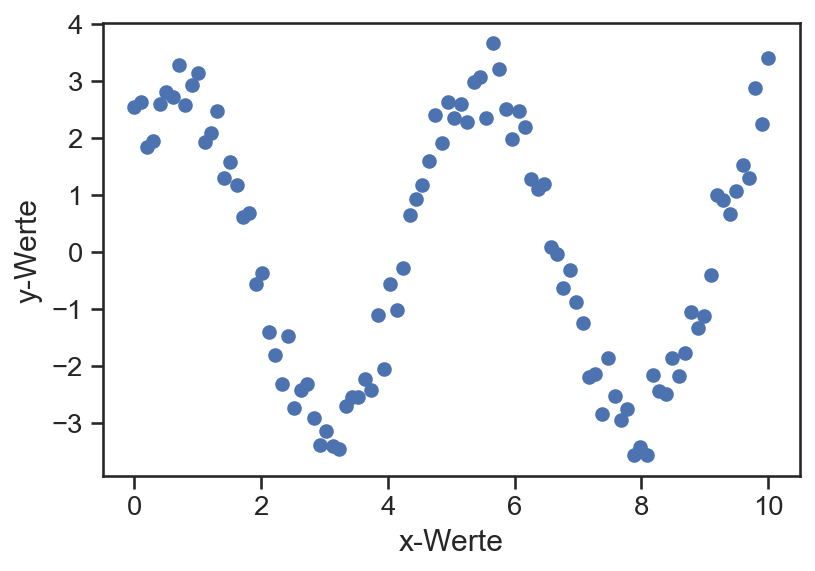

In [2]:
x_daten = np.linspace(0, 10, 100)
y_daten = 3*(np.sin(1.3*x_daten + 0.7) + 0.25*(-1 + 2*np.random.random(len(x_daten))))

plt.scatter(x_daten, y_daten)
plt.xlabel('x-Werte')
plt.ylabel('y-Werte');

Die Modellfunktion, welche hier genutzt werden soll, ist eine Sinus-Funktion. Diese hat jedoch die Amplitude, Frequenz und Phasenverschiebung als frei bestimmbare Parameter:

$$\sf f(x) = p_1 \cdot \sin\left(p_2 \cdot x + p_3\right)$$

Folgende Pyhton Funktion wertet die obige Funktion an der Stelle $\sf x$ aus, bei gegebenen Parametern $\sf p_1, p_2, p_3$. 

In [3]:
def modell_funktion(x, p1, p2, p3):
    return p1 * np.sin(p2 * x + p3)

Die Funktion [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) kann zur Bestimmung dieser Parameter genutzt werden. Dazu muss die Modellfunktion, hier `modell_funktion`, als erstes Argument die unabhängige Variable, hier `x`, gefolgt von den Modellparametern, hier `p1, p2, p3`, aufnehmen. Des weiteren müssen noch die x- und y-Werte der Datenpunkte übergeben werden. Neben den Datenpunkten muss auch noch ein initialer Wert für die Suche nach den besten Parameterwerten übergeben werden. Hier wird der Wert von 1 als Anfangswert für alle Parameter verwendet. Im Allgemeinen kann die gefundene Lösung vom Anfangswert abhängig sein. 

In [4]:
import scipy.optimize

In [5]:
res = scipy.optimize.curve_fit(modell_funktion, x_daten, y_daten, (1,1,1))
print(res)

(array([3.03720168, 1.29555363, 0.74109596]), array([[ 3.27322794e-03, -1.12277111e-05,  1.99770915e-05],
       [-1.12277111e-05,  4.45397092e-05, -2.36385856e-04],
       [ 1.99770915e-05, -2.36385856e-04,  1.61718717e-03]]))


Das Ergebnis des Funktionsaufrufs von `curve_fit` ist ein Tupel, dessen erstes Element die Parameterwerte enthält, welche bei der gegebenen Modellfunktion die Daten am besten fitten. Hier also

In [6]:
print(res[0])

[3.03720168 1.29555363 0.74109596]


Da der Beispieldatensatz mittels einer verrauschten Sinus-Funktion generiert wurde, ist eine direkte Überprüfung dieser Werte möglich. Bei der Generierung wurden die Zahlenwerte $\sf p_1 = 3, p_2 = 1.3, p_3=0.7$ verwendet. Die gefitteten Werte liegen nahe an den vorgegebenen und der Unterschied wird durch das Rauschen verursacht. Als visuellen Vergleich können die Messdaten und die gefittete Modellfunktion gemeinsam dargestellt werden.  

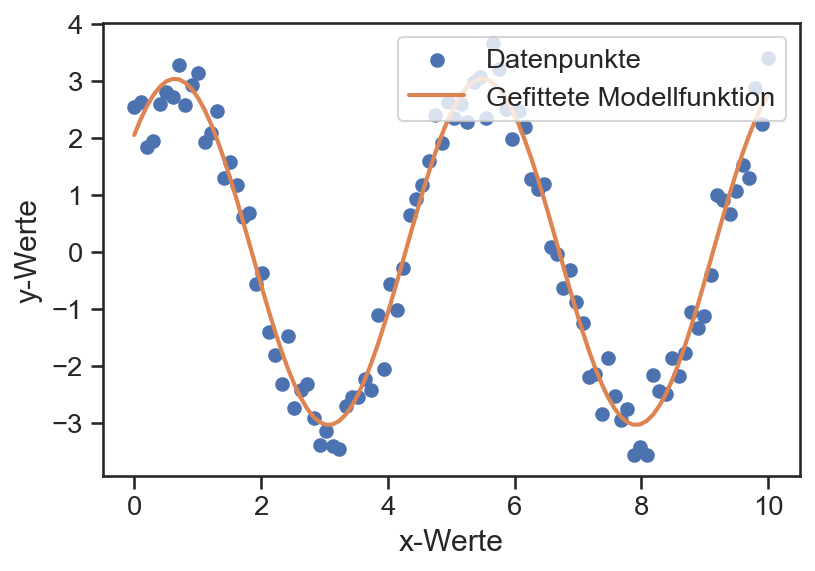

In [7]:
p1, p2, p3 = res[0]
plt.scatter(x_daten, y_daten, label='Datenpunkte')
plt.plot(x_daten, modell_funktion(x_daten, p1, p2, p3), color='C1', lw=2, label='Gefittete Modellfunktion')
plt.legend(loc='upper right')

plt.xlabel('x-Werte')
plt.ylabel('y-Werte');

Häufig werden auch stückweise definierte Modellfunktionen benötigt. Das folgende Beispiel zeigt wie dies anhand des folgenden Datensatzes umgesetzt werden kann.

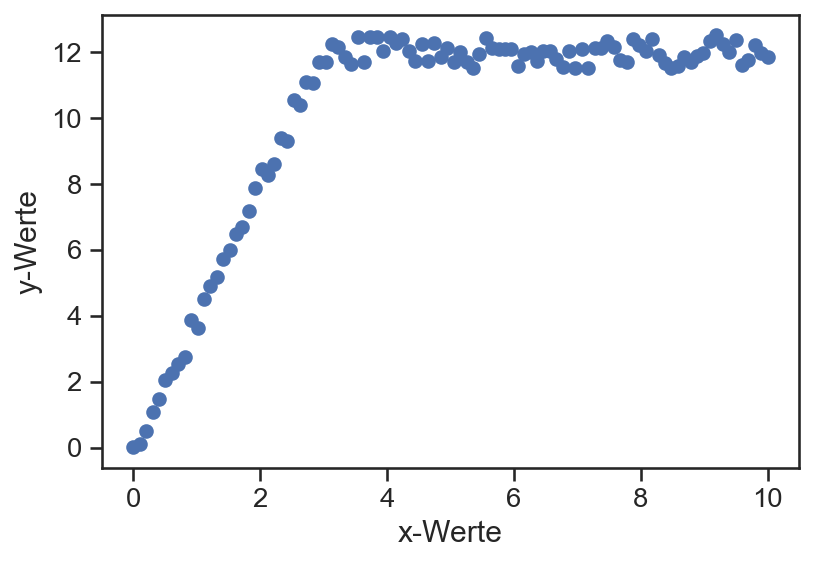

In [8]:
x_ld = np.linspace(0, 10, 100)
y_ld = np.zeros_like(x_ld)
y_ld[x_ld < 3] = x_ld[x_ld < 3] * 4
y_ld[x_ld >= 3] = 12

y_ld += 0.5*(2*np.random.random(len(x_ld))-1)

plt.scatter(x_ld, y_ld)
plt.xlabel('x-Werte')
plt.ylabel('y-Werte');

In diesem Fall wird nach einer passenden stückweise konstanten bzw. linearen Funktion gesucht. Diese hat zwei Parameter und kann wie folgt definiert werden

$$\sf f(x) = \begin{cases}
\sf p_1\cdot x & \sf x < p_2 \\
\sf p_1\cdot p_2 & \sf x \ge p_2
\end{cases}$$

Dabei entspricht $\sf p_1$ der Steigung im ersten Teil der Funktion und $\sf p_2$ gibt den x-Wert an, an welchem der zweite Teil anfängt, welcher konstant ist und stetig zum erten Teil ist.

Die Implementierung in Python sieht mit Hilfe der Funktion [numpy.piecewise](https://numpy.org/doc/stable/reference/generated/numpy.piecewise.html) wie folgt aus.

In [9]:
def modell_funktion_ld(x, p1, p2):
    def teil_1(x):
        return p1*x
    def teil_2(x):
        return p1*p2
    return np.piecewise(x, [x<p2, x>=p2], [teil_1, teil_2])

Wie oben kann nun die Funktion `curve_fit` eingesetzt werden.

In [10]:
res = scipy.optimize.curve_fit(modell_funktion_ld, x_ld, y_ld, (1,1))
print(res[0])

[3.98037249 3.01220558]


Der visuelle Vergleich zeigt, dass auch hier passende Werte für die Modellparameter gefunden werden konnten.

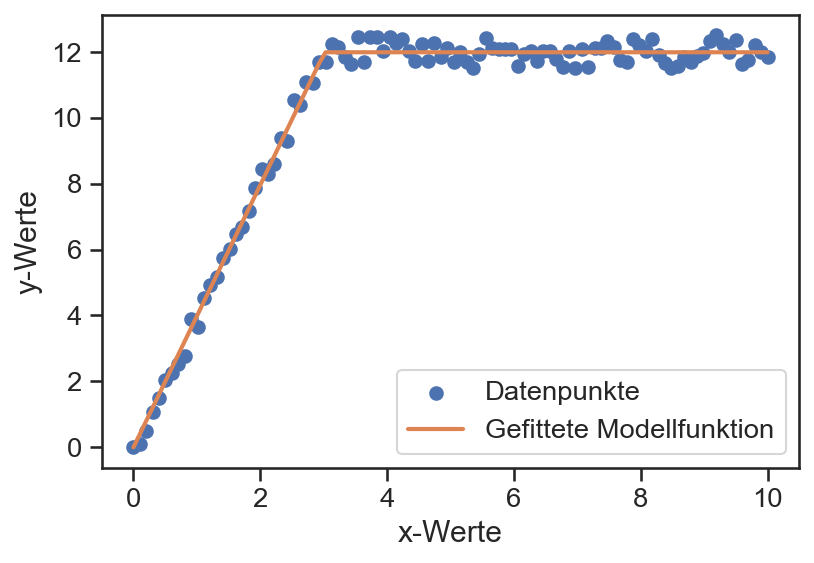

In [11]:
p1, p2 = res[0]
plt.scatter(x_ld, y_ld, label='Datenpunkte')
plt.plot(x_ld, modell_funktion_ld(x_ld, p1, p2), color='C1', lw=2, label='Gefittete Modellfunktion')
plt.legend(loc='lower right')

plt.xlabel('x-Werte')
plt.ylabel('y-Werte');

Im allgemeinen kann es passieren, insbesondere bei komplexen Problemen, dass nicht optimale Parameter gefunden weren konnten. An dieser Stelle kann eine Variation der Anfangswerte helfen.